In [1]:
import pandas as pd
import numpy as np
pd.set_option('max_columns', None)

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, classification_report, recall_score

In [2]:
df_diab = pd.read_csv('data/diabetes_data.csv')
df_heart = pd.read_csv('data/heart_disease_data.csv')

In [3]:
df_heart.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,IsMale
0,40,True,289,False,172,False,0.0,1,False,False,True,False,False,False,True,False,True
1,49,True,180,False,156,False,1.0,0,True,False,False,True,False,False,True,False,False
2,37,True,283,False,98,False,0.0,1,False,False,True,False,False,False,False,True,True
3,48,True,214,False,108,True,1.5,0,True,True,False,False,False,False,True,False,False
4,54,True,195,False,122,False,0.0,1,False,False,False,True,False,False,True,False,True


In [4]:
df_diab.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Age,Education,Income,IsMale,Diabetes
0,False,False,False,66.0,False,False,False,False,True,True,False,True,False,5.0,0.0,30.0,True,9.0,4.0,5.0,False,True
1,False,False,False,34.0,False,False,False,True,False,True,False,True,False,3.0,0.0,0.0,False,7.0,6.0,8.0,False,True
2,False,False,False,30.0,False,False,False,True,True,True,False,True,False,3.0,0.0,2.0,False,6.0,6.0,8.0,True,True
3,False,False,False,39.0,False,False,False,True,True,True,False,True,False,2.0,2.0,10.0,True,4.0,5.0,5.0,False,True
4,False,False,False,37.0,True,False,False,False,False,True,False,True,False,2.0,0.0,0.0,False,7.0,6.0,7.0,True,True


# Algorithms to Explore
* Decision Trees (with pruning)
* Neural Network
* Boosting (GB)
* SVM
* kNN

In [5]:
X_diab = df_diab.drop('Diabetes', axis=1)
y_diab = df_diab['Diabetes']

X_train_diab, X_test_diab, y_train_diab, y_test_diab = train_test_split(X_diab, y_diab, random_state=0)

X_heart = df_heart.drop('HeartDisease', axis=1)
y_heart = df_heart['HeartDisease']

X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(X_heart, y_heart, random_state=0)

## ADA Boosting

In [6]:
def ada_validation(base_estimator, X_train, y_train, X_test, y_test, param, min_val, max_val, step=1, params={}):
    scores = []
    best_score = 0
    values = [val for val in np.arange(min_val, max_val + 1, step)]
    for value in values:
        params.update({'random_state':0, param: value})
        cur_ada = AdaBoostClassifier(base_estimator=base_estimator, **params)
        cur_ada.fit(X_train, y_train)
        cur_score = get_recall(cur_ada, X_test, y_test)
        scores.append(cur_score)
        if cur_score > best_score:
            best_score = cur_score
            print(f'best score: {best_score} --- {param}: {value}', end='\r')
    print(end='\n')
    return scores, values

In [7]:
def get_recall(model, X_test, y_test):
    y_pred = model.predict(X_test)
    recall = classification_report(y_test, y_pred, output_dict=True)['True']['recall']
    return recall

In [8]:
ada_baseline_diab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3, min_samples_leaf=.001,random_state=0),random_state=0)
ada_baseline_diab.fit(X_train_diab, y_train_diab)
print('diabetes baseline score:', get_recall(ada_baseline_diab, X_test_diab, y_test_diab))

diabetes baseline score: 0.7989182309895004


In [9]:
ada_baseline_heart = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, min_samples_leaf=.066, random_state=0),random_state=0)
ada_baseline_heart.fit(X_train_heart, y_train_heart)
print('heart disease baseline score:', get_recall(ada_baseline_heart,X_test_heart, y_test_heart))

heart disease baseline score: 0.8823529411764706


Diabetes
best score: 0.8186446070633153 --- n_estimators: 5

Heart Disease
best score: 0.907563025210084 --- n_estimators: 655


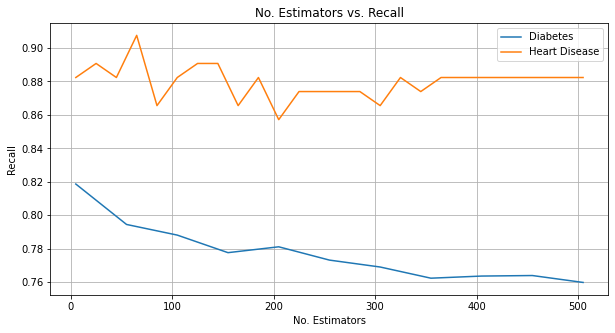

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
print('Diabetes')
diab_layer_scores, diab_layer_values = ada_validation(DecisionTreeClassifier(max_depth=3, min_samples_leaf=.001,random_state=0),
                                                      X_train_diab, y_train_diab, 
                                                      X_test_diab, y_test_diab,
                                                      'n_estimators', 5, 505, 50)
print('\nHeart Disease')
heart_layer_scores, heart_layer_values = ada_validation(DecisionTreeClassifier(max_depth=2, min_samples_leaf=.066, random_state=0),
                                                        X_train_heart, y_train_heart, 
                                                        X_test_heart, y_test_heart,
                                                        'n_estimators', 5, 505, 20)
ax.plot(diab_layer_values, diab_layer_scores, label='Diabetes')
ax.plot(heart_layer_values, heart_layer_scores, label='Heart Disease')
ax.grid()
ax.set_xlabel('No. Estimators')
ax.set_title('No. Estimators vs. Recall')
plt.legend()
ax.set_ylabel('Recall');

Diabetes
best score: 0.8205536111994909 --- learning_rate: 0.90000000000000026

Heart Disease
best score: 0.907563025210084 --- learning_rate: 0.1


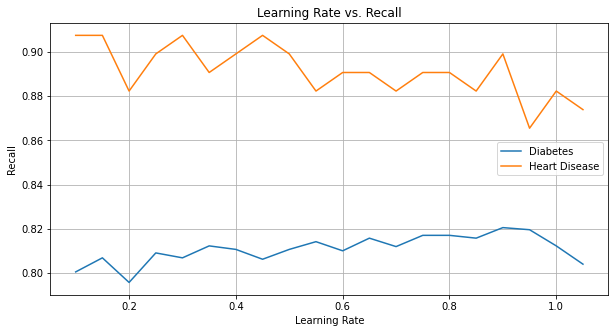

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
print('Diabetes')
diab_layer_scores, diab_layer_values = ada_validation(DecisionTreeClassifier(min_samples_leaf=.001,max_depth=3, random_state=0),
                                                      X_train_diab, y_train_diab, 
                                                      X_test_diab, y_test_diab,
                                                      'learning_rate', .1, .1, .05,
                                                      {'n_estimators':10})
print('\nHeart Disease')
heart_layer_scores, heart_layer_values = ada_validation(DecisionTreeClassifier(max_depth=2, min_samples_leaf=.066, random_state=0),
                                                        X_train_heart, y_train_heart, 
                                                        X_test_heart, y_test_heart,
                                                        'learning_rate', .1, .1, .05,
                                                        {'n_estimators':20})
ax.plot(diab_layer_values, diab_layer_scores, label='Diabetes')
ax.plot(heart_layer_values, heart_layer_scores, label='Heart Disease')
ax.grid()
ax.set_xlabel('Learning Rate')
ax.set_title('Learning Rate vs. Recall')
plt.legend()
ax.set_ylabel('Recall');

In [12]:
diab_params = {
    'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=0),
    'n_estimators':10, 
    'learning_rate':.95, 
    'random_state':0
}
diab_ada = AdaBoostClassifier(**diab_params)
diab_ada.fit(X_train_diab, y_train_diab)
get_recall(diab_ada, X_test_diab, y_test_diab)

0.8211899459115495

In [13]:
heart_params = {
    'base_estimator':DecisionTreeClassifier(max_depth=2, min_samples_leaf=9, random_state=0),
    'n_estimators':20, 
    'learning_rate':.1, 
    'random_state':0
}
heart_ada = AdaBoostClassifier(**heart_params)
heart_ada.fit(X_train_heart, y_train_heart)
get_recall(heart_ada, X_test_heart, y_test_heart)

0.907563025210084

In [14]:
import json
import pickle as pk
with open('params/ada_params.pk', 'wb') as f:
    params = {'diab':diab_params, 'heart':heart_params}
    pk.dump(params, f)